In [1]:
import pandas as pd
import numpy as np
import cv2
import os
import re
import sys
from collections import Counter
import seaborn as sns
import pyarrow as pa
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from multiprocessing import Pool

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.applications.resnet_v2 import ResNet50V2


from datetime import datetime
import pickle
import scipy.stats as stats
import os
import sklearn.metrics

Using TensorFlow backend.


In [2]:
y = pd.read_csv("data/train.csv")
yEval = pd.read_csv("data/test.csv")
classMap = pd.read_csv("data/class_map.csv")

In [3]:
labels = ["grapheme_root","vowel_diacritic","consonant_diacritic"]

In [4]:
y = y.set_index("image_id")

In [5]:
tables = [pq.read_table('data/train_image_data_{0}.parquet'.format(i)) for i in range(4)]
tables = [table.to_pandas() for table in tables]
df = pd.concat(tables)
df = df.set_index("image_id")
tables = [pq.read_table('data/test_image_data_{0}.parquet'.format(i)) for i in range(4)]
tables = [table.to_pandas() for table in tables]
dfEval = pd.concat(tables)
dfEval = dfEval.set_index("image_id")
del tables

In [6]:
size=(60,60)

def transformImg(img):
    img=255-img
    mu = cv2.moments(img, False)
    x, y= mu["m10"]/mu["m00"] , mu["m01"]/mu["m00"]
    M = np.float32([[1,0,(236/2)-x],[0,1,(137/2)-y]])
    img = cv2.warpAffine(img,M,(img.shape[1],img.shape[0]))
    img = cv2.resize(img, (size[0],size[1]))
    return img

imgs=df.values.reshape(-1,137,236)
with Pool() as p:
    imap=p.imap(transformImg,imgs)
    imgs=list(tqdm(imap,total=imgs.shape[0]))

X = np.asarray(imgs).astype(np.float32)/255.0
X = X.reshape(-1,size[0],size[1],1)

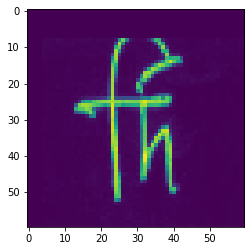

In [7]:
plt.imshow(X[15].reshape(size))

In [8]:
def getModel(cat=168):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(*size,1)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(cat, activation='softmax'))
    return model

def getModel2(cat=168):
    model = Sequential()
    model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='SAME', activation='relu', input_shape=(*size, 1)))
    model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='SAME', activation='relu'))
    model.add(BatchNormalization(momentum=0.15))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=32, kernel_size=(5, 5), padding='SAME', activation='relu'))
    model.add(Dropout(rate=0.3))

    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='SAME', activation='relu'))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='SAME', activation='relu'))
    model.add(BatchNormalization(momentum=0.15))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=64, kernel_size=(5, 5), padding='SAME', activation='relu'))
    model.add(Dropout(rate=0.3))

    model.add(Flatten())
    model.add(Dense(256, activation = "relu"))
    model.add(Dropout(0.10))
    model.add(Dense(192, activation = "relu"))
    model.add(Dropout(0.10))
    model.add(Dense(cat, activation = "softmax"))
    return model

def getModel3(cat=168):
    model = Sequential()
    model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='SAME', activation='relu', input_shape=(*size, 1)))
    model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='SAME', activation='relu'))
    model.add(BatchNormalization(momentum=0.15))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=32, kernel_size=(5, 5), padding='SAME', activation='relu'))
    model.add(Dropout(rate=0.3))

    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='SAME', activation='relu'))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='SAME', activation='relu'))
    model.add(BatchNormalization(momentum=0.15))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=64, kernel_size=(5, 5), padding='SAME', activation='relu'))
    model.add(Dropout(rate=0.3))

    model.add(Conv2D(filters=128, kernel_size=(3, 3), padding='SAME', activation='relu'))
    model.add(Conv2D(filters=128, kernel_size=(3, 3), padding='SAME', activation='relu'))
    model.add(BatchNormalization(momentum=0.15))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=128, kernel_size=(5, 5), padding='SAME', activation='relu'))
    model.add(Dropout(rate=0.3))

    model.add(Flatten())
    model.add(Dense(512, activation = "relu"))
    model.add(Dropout(0.10))
    model.add(Dense(256, activation = "relu"))
    model.add(Dropout(0.10))
    model.add(Dense(192, activation = "relu"))
    model.add(Dropout(0.10))
    model.add(Dense(cat, activation = "softmax"))
    return model


def getModel4(cat=168):
    model = Sequential()
    model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='SAME', activation='relu', input_shape=(*size, 1)))
    model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='SAME', activation='relu'))
    model.add(BatchNormalization(momentum=0.15))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=32, kernel_size=(5, 5), padding='SAME', activation='relu'))
    model.add(Dropout(rate=0.3))

    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='SAME', activation='relu'))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='SAME', activation='relu'))
    model.add(BatchNormalization(momentum=0.15))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=64, kernel_size=(5, 5), padding='SAME', activation='relu'))
    model.add(Dropout(rate=0.3))

    model.add(Conv2D(filters=128, kernel_size=(3, 3), padding='SAME', activation='relu'))
    model.add(Conv2D(filters=128, kernel_size=(3, 3), padding='SAME', activation='relu'))
    model.add(BatchNormalization(momentum=0.15))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=128, kernel_size=(5, 5), padding='SAME', activation='relu'))
    model.add(Dropout(rate=0.3))
    
    model.add(Conv2D(filters=256, kernel_size=(3, 3), padding='SAME', activation='relu'))
    model.add(Conv2D(filters=256, kernel_size=(3, 3), padding='SAME', activation='relu'))
    model.add(BatchNormalization(momentum=0.15))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=256, kernel_size=(5, 5), padding='SAME', activation='relu'))
    model.add(Dropout(rate=0.3))

    model.add(Flatten())
    model.add(Dense(512, activation = "relu"))
    model.add(Dropout(0.10))
    model.add(Dense(256, activation = "relu"))
    model.add(Dropout(0.10))
    model.add(Dense(192, activation = "relu"))
    model.add(Dropout(0.10))
    model.add(Dense(cat, activation = "softmax"))
    return model


def getModel5(cat=168):
    model = Sequential()
    model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='SAME', activation='relu', input_shape=(*size, 1)))
    model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='SAME', activation='relu'))
    model.add(BatchNormalization(momentum=0.15))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=32, kernel_size=(5, 5), padding='SAME', activation='relu'))
    model.add(Dropout(rate=0.3))

    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='SAME', activation='relu'))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='SAME', activation='relu'))
    model.add(BatchNormalization(momentum=0.15))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=64, kernel_size=(5, 5), padding='SAME', activation='relu'))
    model.add(Dropout(rate=0.3))

    model.add(Conv2D(filters=128, kernel_size=(3, 3), padding='SAME', activation='relu'))
    model.add(Conv2D(filters=128, kernel_size=(3, 3), padding='SAME', activation='relu'))
    model.add(BatchNormalization(momentum=0.15))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=128, kernel_size=(5, 5), padding='SAME', activation='relu'))
    model.add(Dropout(rate=0.3))
    
    model.add(Conv2D(filters=256, kernel_size=(3, 3), padding='SAME', activation='relu'))
    model.add(Conv2D(filters=256, kernel_size=(3, 3), padding='SAME', activation='relu'))
    model.add(BatchNormalization(momentum=0.15))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=256, kernel_size=(5, 5), padding='SAME', activation='relu'))
    model.add(Dropout(rate=0.3))
    
    model.add(Conv2D(filters=512, kernel_size=(3, 3), padding='SAME', activation='relu'))
    model.add(Conv2D(filters=512, kernel_size=(3, 3), padding='SAME', activation='relu'))
    model.add(BatchNormalization(momentum=0.15))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=512, kernel_size=(5, 5), padding='SAME', activation='relu'))
    model.add(Dropout(rate=0.3))

    model.add(Flatten())
    model.add(Dense(1024, activation = "relu"))
    model.add(Dropout(0.10))
    model.add(Dense(512, activation = "relu"))
    model.add(Dropout(0.10))
    model.add(Dense(cat, activation = "softmax"))
    return model



In [9]:
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.9)

In [10]:
early_stopping =  EarlyStopping(monitor='val_loss', min_delta=0.0, patience=3)

In [ ]:
for i in tqdm(range(100)):
    for label in tqdm(labels):
        cat=len(set(y[label]))
        for model in [getModel(cat), getModel2(cat), getModel3(cat), getModel4(cat),getModel5(cat),]:
            model.compile(optimizer=Adam(), metrics=["acc"],loss="categorical_crossentropy")
            model.fit(X_train,to_categorical(y_train[label]),epochs=20,validation_data=(X_test,to_categorical(y_test[label])), callbacks=[early_stopping])
            os.makedirs(label,exist_ok=True)
            with open('./{0}/{1}.dump'.format(label,int(float(datetime.now().timestamp()))), 'wb') as f:
                pickle.dump(model,f)

Train on 180756 samples, validate on 20084 samples
Epoch 1/20
180756/180756 [==============================] - 58s 322us/step - loss: 3.3267 - acc: 0.2105 - val_loss: 2.0474 - val_acc: 0.4758
Epoch 2/20
180756/180756 [==============================] - 58s 319us/step - loss: 2.3253 - acc: 0.3833 - val_loss: 1.5988 - val_acc: 0.5774
Epoch 3/20
180756/180756 [==============================] - 58s 320us/step - loss: 1.9622 - acc: 0.4629 - val_loss: 1.3910 - val_acc: 0.6316
Epoch 4/20
180756/180756 [==============================] - 58s 322us/step - loss: 1.7479 - acc: 0.5140 - val_loss: 1.2316 - val_acc: 0.6749
Epoch 5/20
180756/180756 [==============================] - 58s 319us/step - loss: 1.5824 - acc: 0.5536 - val_loss: 1.1889 - val_acc: 0.6765
Epoch 6/20
180756/180756 [==============================] - 58s 320us/step - loss: 1.4575 - acc: 0.5834 - val_loss: 1.1099 - val_acc: 0.6976
Epoch 7/20
180756/180756 [==============================] - 58s 319us/step - loss: 1.3663 - acc: 0.6058

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



180756/180756 [==============================] - 87s 479us/step - loss: 1.1615 - acc: 0.6868 - val_loss: 0.7194 - val_acc: 0.8041
Epoch 3/20
180756/180756 [==============================] - 87s 483us/step - loss: 0.8443 - acc: 0.7757 - val_loss: 0.5731 - val_acc: 0.8446
Epoch 4/20
180756/180756 [==============================] - 87s 481us/step - loss: 0.6946 - acc: 0.8156 - val_loss: 0.5367 - val_acc: 0.8569
Epoch 5/20
 77408/180756 [===========>..................] - ETA: 47s - loss: 0.6174 - acc: 0.8349

In [ ]:
ans = pd.DataFrame(index=y_test.index)
for label in labels:
    y_preds = []
    for file in tqdm(os.listdir("./{0}".format(label))):
        with open("./{0}/{1}".format(label,file),"rb") as f:
            model=pickle.load(f)
            try:
                y_pred = model.predict(X_testl)
                y_pred = np.argmax(y_pred, axis=1)
                y_preds.append(y_pred)
            except:
                print(model)
    y_preds = np.asarray(y_preds)
    y_pred, _ = stats.mode(y_preds,axis=0)
    y_pred = y_pred.reshape(-1,)
    ans[label] = y_pred

In [ ]:
scores = []
for label in labels:
    y_true_subset = y_test[label]
    y_pred_subset = ans[label]
    scores.append(sklearn.metrics.recall_score(
        y_true_subset, y_pred_subset, average='macro'))
final_score = np.average(scores, weights=[2,1,1])

In [ ]:
final_score